In [4]:
import os
import numpy as np
import torch
import open_clip
#import clip
from PIL import Image
from open_clip import tokenizer

import IPython.display
import matplotlib.pyplot as plt
from collections import OrderedDict

device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/32", device=device)
model, _, preprocess = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k_augreg')

model.eval()
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 179,385,345
Context length: 77
Vocab size: 49408


In [5]:
# images in skimage to use and their textual descriptions
descriptions = {
    "artist": "a street artist playing metal instructments",
    "helicopters": "helicopters flying overhead",
    "church": "a portrait of Jesus inside church",
    "stadium": "ancient olympic stadium of Greece",
    "demonstration": "a group of people demonstrating on the street",
    "woman": "a woman wearing a red jacket",
    "guitar": "a man playing guitar under the tree", 
    "soilders": "a group of soldiers marching on the street"
}

<Figure size 1600x500 with 0 Axes>

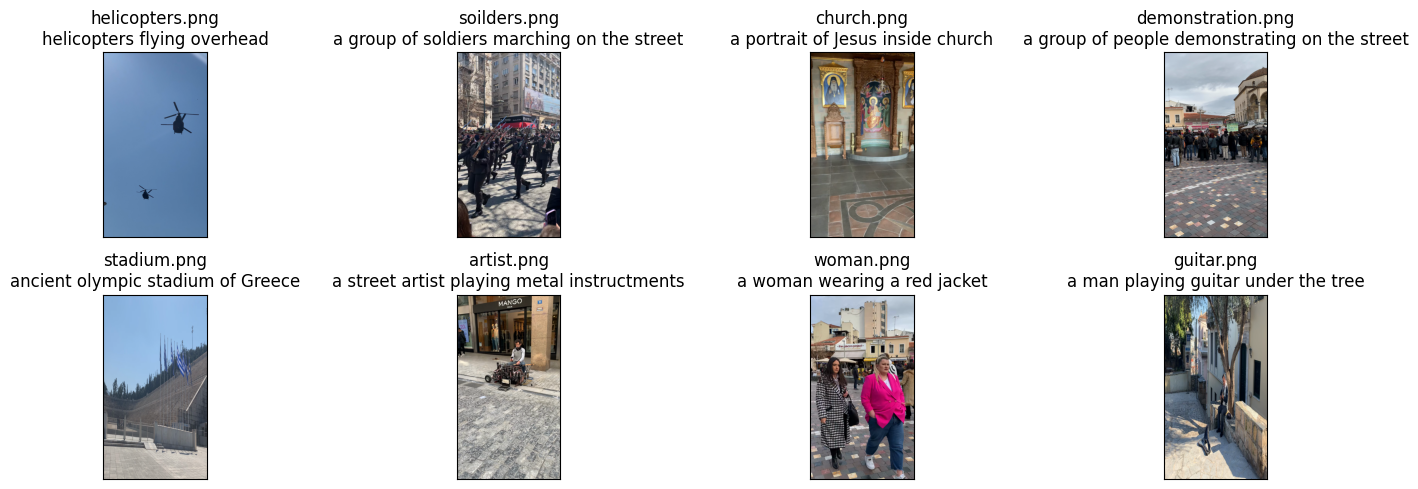

In [6]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir("/Users/royzheng/Downloads/tmp/combine/subset") if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join("/Users/royzheng/Downloads/tmp/combine/subset", filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

In [7]:
# Building features
# We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

image_input = torch.tensor(np.stack(images))
text_tokens = tokenizer.tokenize(["This is " + desc for desc in texts])

In [8]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [9]:
# Calculating cosine similarity
# We normalize the features and calculate the dot product of each pair.

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

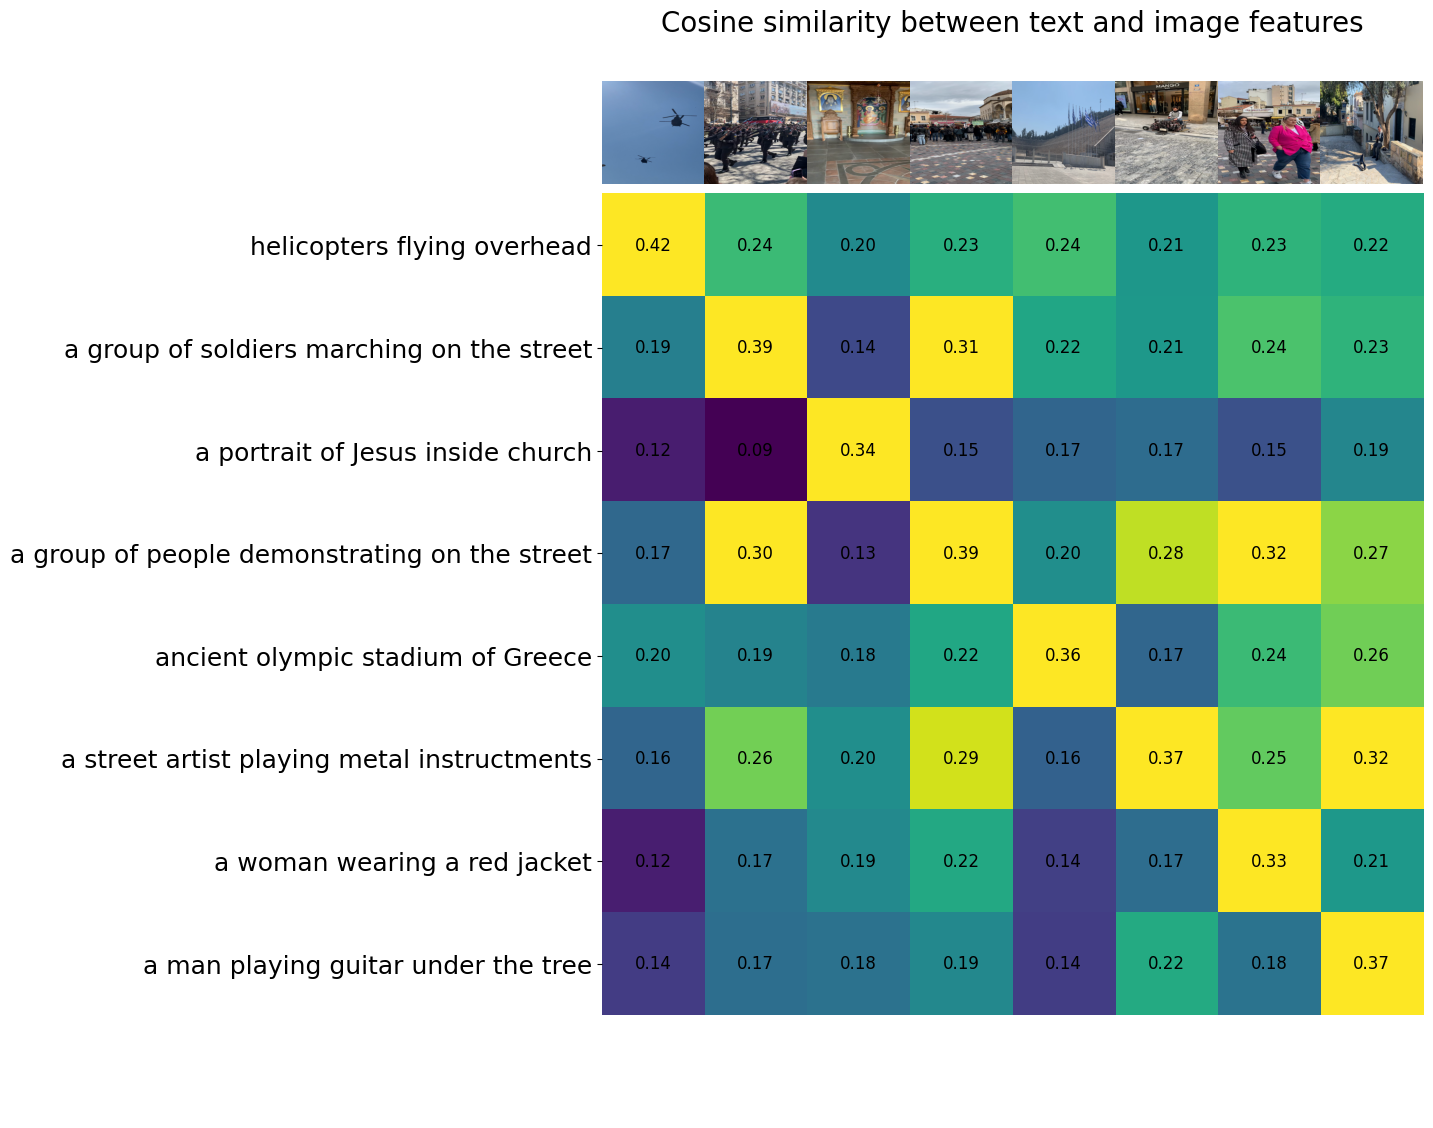

In [10]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)